# Notebook - BCC mock

In [22]:
from xd import *
from utils import *
import esutil
import healpy as hp
from systematics import *
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### calling BCC-buzzard 

Remove objects having crazy colors or undetected in all bands.

In [23]:
def priorCut_buz(merged_buz):
    basicmask = (
                 ( merged_buz['MAG_G'] > 15.0 ) & ( merged_buz['MAG_G'] < 25.0 ) &
                 ( merged_buz['MAG_R'] > 15.0 ) & ( merged_buz['MAG_R'] < 25.0 ) &
                 ( merged_buz['MAG_I'] > 15.0 ) & ( merged_buz['MAG_I'] < 22.0 ) &
                 ( merged_buz['MAG_Z'] > 15.0 ) & ( merged_buz['MAG_Z'] < 25.0 ) &
                 ( merged_buz['MAG_G'] - merged_buz['MAG_R'] < 2.5 ) &
                 ( merged_buz['MAG_G'] - merged_buz['MAG_R'] > -0.5 ) &
                 #( merged_buz['MAG_G'] - merged_buz['MAG_R'] > 0.0 ) &
                 ( merged_buz['MAG_R'] - merged_buz['MAG_I'] < 2.0 ) &
                 ( merged_buz['MAG_R'] - merged_buz['MAG_I'] > -0.5 )
                 #( merged_buz['MAG_R'] - merged_buz['MAG_I'] > 0.0 )
                 )
    return merged_buz[basicmask]

In [25]:
# code for unfolding sdss-buz
def unfold_buz(buz_sdss):
    #buz_sdss = fitsio.read(path+name)
    dtype = [('OMAG_'+f, float) for f in ['G', 'R', 'I', 'Z']] \
    +  [('OMAGERR_'+f, float) for f in ['G', 'R', 'I', 'Z']] \
    #+ [('AMAG_'+f, float) for f in ['G', 'R', 'I', 'Z']] \
    #+ [('LMAG_'+f, float) for f in ['G', 'R', 'I', 'Z']] \
    #+ [('TMAG_'+f, float) for f in ['G', 'R', 'I', 'Z']]
    
    buz_sdss_df = np.zeros((buz_sdss.size,), dtype=dtype)
    
    for i, f in enumerate(['G', 'R', 'I','Z']):
        buz_sdss_df['OMAG_'+f] = buz_sdss['OMAG'][:,i+1]
        buz_sdss_df['OMAGERR_'+f] = buz_sdss['OMAGERR'][:,i+1]
        #buz_sdss_df['AMAG_'+f] = buz_sdss['AMAG'][:,i+1]
        #buz_sdss_df['LMAG_'+f] = buz_sdss['LMAG'][:,i+1]
        #buz_sdss_df['TMAG_'+f] = buz_sdss['TMAG'][:,i+1]
    
    #fitsio.write(path+'Buzzard_v1.1_stripe82_mag.unfold.60.fit', buz_sdss_df)
    return buz_sdss_df

In [26]:
# 24  40  60  84 112 144 176 208
catnum = [24, 84, 112, 144, 176]
path = '/n/des/lee.5922/data/buzzard/'
for c in catnum:
    print c
    buz_sdss = fitsio.read(path+'Buzzard_v1.1_stripe82_mag.'+str(c)+'.fit') 
    buz_sdss = unfold_buz(buz_sdss)
    fitsio.write(path+'Buzzard_v1.1_stripe82_mag.unfold.'+str(c)+'.fit', buz_sdss)

24
84
112
144
176


In [ ]:
# calling map 
GoldMask = callingEliGoldMask()


Calling buzzard des and sdss catalogs.

In [ ]:
path = '/n/des/lee.5922/data/buzzard/'
buz = np.hstack([fitsio.read(path+'Buzzard_v1.1_Y1A1.40.fit'), fitsio.read(path+'Buzzard_v1.1_Y1A1.60.fit')])
buz_sdss = np.hstack([fitsio.read(path+'Buzzard_v1.1_stripe82_mag.unfold.40.fit'), \
                      fitsio.read(path+'Buzzard_v1.1_stripe82_mag.unfold.60.fit')]) # buzzard sdss side photometry
merged_buz = mergeCatalogsUsingPandas(des=buz, gold=buz_sdss, how = 'outer', key=None, suffixes = ['',''],\
                                      left_index=True, right_index=True)
merged_buz = priorCut_buz(merged_buz)

In [ ]:
merged_buz = Cuts.keepGoodRegion(merged_buz)

In [ ]:
A = getHPArea(cat=merged_buz, nside=4096)
print merged_buz.size /A, merged_buz.size

Make Fake CMASS sample

In [ ]:
dperp = ( merged_buz['OMAG_R'] - merged_buz['OMAG_I'] ) - ( merged_buz['OMAG_G'] - merged_buz['OMAG_R'])/8.0
fakemask =(
            ( merged_buz['OMAG_I'] < 19.86 + 1.6 * (dperp - 0.8)) &
            #( merged_buz['OMAG_I'] > 17.5 ) & ( merged_buz['OMAG_I'] < 20.0 ) &
            ( merged_buz['TMAG_I'] > 17.5 ) & ( merged_buz['TMAG_I'] < 20.0 ) &
            ( merged_buz['OMAG_R'] - merged_buz['OMAG_I'] < 2.0 ) &
            #( merged_buz['OMAG_R'] - merged_buz['OMAG_I'] > 0.0 ) &
            ( dperp > 0.55 )
            )
fakecmass = merged_buz[fakemask]

Fit data with XD

In [ ]:
# Divide sample into train and test
(trainInd, testInd), _ = split_samples(merged_buz, merged_buz, [0.2,0.8], random_state=0)
des_train = merged_buz[trainInd]
des_test = merged_buz[testInd]

m1, m2 = esutil.numpy_util.match(fakecmass['ID'], des_train['ID'])
cmass_mask = np.zeros(des_train.size, dtype=bool)
cmass_mask[m2] = 1
fakecmass_train, nocmass_train = des_train[cmass_mask], des_train[~cmass_mask]

In [ ]:
des_train.size, fakecmass.size, fakecmass_train.size

In [ ]:
#rm pickle/buz_XD_cmass_tor_noricut6.pkl

In [ ]:
# Fitting
pickleFileName = 'pickle/buz_XD_cmass_tor_noricut6.pkl'
clf_cmass = XD_fitting2( fakecmass_train, pickleFileName = pickleFileName, \
                  #init_params= 'pickle/buz_XD_cmass_tor_noricut6.pkl',\
                        suffix = '_cmass', n_cl = 10 )

In [ ]:
pickleFileName = 'pickle/buz_XD_no_tor_noricut6.pkl'
rows = np.random.choice(nocmass_train.size, size=int(nocmass_train.size/10.))                    
clf_no = XD_fitting2( nocmass_train, pickleFileName = pickleFileName, \
                  init_params= 'pickle/buz_XD_no_tor_noricut5.pkl', \
                     suffix = '_no', n_cl = 25 )

Assign Fake cmass memb prob to test sample

In [ ]:
cmass_fraction = fakecmass_train.size * 1./des_train.size
print 'cmass_fraction', cmass_fraction
from xd import assignCMASSProb
des_test = assignCMASSProb( des_test, clf_cmass, clf_no, cmass_fraction = cmass_fraction )
#buz_test = assignCMASSProb( buz_test, clf_cmass, clf_no, cmass_fraction = cmass_fraction )

###### Check model probability

In [ ]:
probability_calibration( des = des_test, cmass_des = fakecmass, matchID= 'ID', prefix = 'test' )

###### Make DMASS by resampling

In [ ]:
dmass_buz, _ = resampleWithPth( des_test, pstart = 0, pmax = 1.0 )

#### Comparison of error-convolved model and observed data

In [ ]:
cmass_model = clf_cmass.sample(fakecmass_train.size)
no_model = clf_no.sample(nocmass_train.size)

X_train, Xcov_train = mixing_color_buz(des_train)
X_test,_ = mixing_color_buz(des_test)

noisy_cmass_model = add_errors_multiprocessing(cmass_model, X_train[cmass_mask], Xcov_train[cmass_mask])
nosiy_no_model = add_errors_multiprocessing(no_model, X_train[~cmass_mask], Xcov_train[~cmass_mask])

In [ ]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [.0,2.5], [-.5,1.5], [0.0,.8]]
doVisualization_1d_NperA( noisy_cmass_model, X_train[cmass_mask], area=[1,1], labels = labels, ranges = ranges,\
                         name =['model','obs' ], nbins=100, prefix='buz_model_cmass_')
doVisualization_1d_NperA( nosiy_no_model, X_train[~cmass_mask], area=[1,1], labels = labels, ranges = ranges,\
                         name =['model','obs' ], nbins=100, prefix='buz_model_no_')

#### Comparison with train and test observational data

In [ ]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [-0.5,2], [-.5,1.5], [0.0,.8]]
#X_buz,_ = mixing_color_buz(buz_test)
rows = np.random.choice(nocmass_train.size, size=int(nocmass_train.size/2.)) 
doVisualization_1d_NperA( X_train[rows,:], X_test, area=[1,8], labels = labels, ranges = ranges,\
                         name =['train','test' ], nbins=100, prefix='buz_all_')

In [ ]:
# Plotting dmass
X_cmass,_ = mixing_color_buz(fakecmass_train)
X_dmass,_ = mixing_color_buz(dmass_buz)
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [0,2], [-.5,1.5], [0.0,.8]]
doVisualization_1d_NperA( X_cmass, X_dmass, area=[2,8], labels = labels, ranges = ranges,\
                         name =['cmass','dmass' ], nbins=100, prefix='buz_dmass_')

#### bias and number density of DMASS

In [ ]:
def getavgbias( cat, pstart=0.0 ):
    from systematics_module.contCorrection import logL_from_mag,logL_to_galaxyBias
    mag = cat['MAG_I']
    z = cat['PHOTOZ_GAUSSIAN']
    logL = logL_from_mag( mag = mag, z = z )
    avg_b = logL_to_galaxyBias(logL = logL)
    print 'avg bias=',avg_b, ' sample size=', mag.size
    return avg_b

In [ ]:
avg_b_cmass = getavgbias( fakecmass_train )
avg_b_dmass = getavgbias( dmass_buz )
print 'num_density', fakecmass_train.size * 4 *1./dmass_buz.size * 100 , '%' 
print 'bias ratio', avg_b_cmass /avg_b_dmass * 100, '%'

----

### Testing Same region with DES SPT

Find heapix index for given range

In [ ]:
# testing for same area of des_gold 
def getHealInd_buz(ra, ra2, dec, dec2):
    #ra = np.linspace(0, 50, 2000)
    #dec = np.random.choice(np.linspace(-52, -50, 10), size = 2000)
    ra = np.linspace(ra, ra2, 2000)
    dec = np.random.choice(np.linspace(dec, dec2, 10), size = 2000)
    #Buzzard rotational matrix
    rmat = np.array([ 0.382192, 0.054546, 0.922472,\
                     -0.924079, 0.025571, 0.381346,\
                     -0.002787, -0.998184, 0.060177 ]).reshape(3,3)
    vec  = hp.ang2vec(-(dec - 90.) * np.pi / 180., ra * np.pi / 180.)
    rvec = np.dot(np.linalg.inv(rmat), vec.T)
    pix  = set(hp.vec2pix(8, *rvec, nest=False))
    print 'Healpix ind ', np.sort(list(pix))
    return np.sort(list(pix))

In [ ]:
#ra, ra2, dec, dec2 = [0, 50, -52, -50]
ra, ra2, dec, dec2 = [320, 360, -1, 1]
pix3 = getHealInd_buz(ra, ra2, dec, dec2)

In [ ]:
# testing for other regions (same with des spt)
path = '/n/des/lee.5922/data/buzzard/'
buz_test_list = []
for p in pix:
    cat = priorCut_buz(fitsio.read(path+'Buzzard_v1.1_Y1A1.'+str(p)+'.fit'))
    cat = Cuts._keepGoodRegion(cat)
    print 'Buzzard_v1.1_Y1A1.'+str(p)+'.fit'
    #cat = assignCMASSProb( cat, clf_cmass, clf_no, cmass_fraction = cmass_fraction ) 
    buz_test_list.append(cat)
    cat = None

In [ ]:
train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
nd =  merged_buz.size/train_area

nd_ratio = []
for i, d in enumerate(buz_test_list):
    test_area = getHPArea(pix = pix[i]) #* 1/5    
    nd_ratio.append(d.size /test_area /nd)

In [ ]:
# histograms
dmass_buz_list = []
for i, p in enumerate(pix):
    dmass_buz , _ = resampleWithPth( buz_test_list[i], pstart = 0, pmax = 1.0 )
    dmass_buz_list.append(dmass_buz)

In [ ]:
train_area = (getHPArea(pix = 40) + getHPArea(pix = 60))/5
#for i in range(len(dmass_buz_list)):
for i, p in enumerate(pix):
    X_buz_dmass, _ = mixing_color_buz(dmass_buz_list[i])
    X_cmass, _ = mixing_color_buz(fakecmass_train)
    X_train,_ = mixing_color_buz(des_train)
    X_test,_ = mixing_color_buz(buz_test_list[i])
    labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
    ranges =  [[17,22.5], [17,22.5], [0,2], [-.5,1.5], [0.0,.8]]
    #test_area = getHPArea(cat=buz_test[i], nside=512)
    test_area = getHPArea(pix = pix[i])
    #doVisualization_1d_NperA( X_cmass, X_buz_dmass, area=[train_area ,test_area], labels = labels, ranges = ranges,\
    #                         name =['cmass','dmass'], nbins=100, prefix='buz_dmass_pix'+str(p)+'_')
    #doVisualization_1d_NperA( X_train, X_test, area=[train_area,test_area], labels = labels, ranges = ranges,\
    #                         name =['train','test' ], nbins=100, prefix='buz_all_pix'+str(p)+'_')
    doVisualization_1d( X_cmass, X_buz_dmass, labels = labels, ranges = ranges,\
                             name =['cmass','dmass'], nbins=100, prefix='buz_dmass_pix'+str(p)+'_')
    doVisualization_1d( X_train, X_test, labels = labels, ranges = ranges,\
                             name =['train','test' ], nbins=100, prefix='buz_all_pix'+str(p)+'_')

In [ ]:
# bias

train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
num_density = fakecmass.size/train_area
print 'num density', num_density
print 'area', test_area
avg_b_cmass = getavgbias( fakecmass )
print '-----------------------------'

nd_ratio_cmass = []
bias_ratio = []
for i,p in enumerate(pix):
    test_area = getHPArea(pix = p)
    num_d = dmass_buz_list[i].size/test_area
    print p, 'num density', num_d, num_d/num_density * 100, '%'
    nd_ratio_cmass.append(num_d/num_density)
    print 'area', test_area
    avg_b_dmass = getavgbias( dmass_buz_list[i] )
    print '-----------------------------'
    bias_ratio.append(avg_b_dmass/avg_b_cmass)

In [ ]:
def grmask(cat):
    gr_mask = (((cat['MAG_G'] - cat['MAG_R']) > 1.3 ) &
               ((cat['MAG_G'] - cat['MAG_R']) < 1.8 ))
    #cat = cat[gr_mask]
    return gr_mask

In [ ]:
gr_train = np.sum(grmask(merged_buz))
test_area = getHPArea(pix = 40) + getHPArea(pix = 60)
n_gr_train = gr_train/test_area

nd_gr = []
for i, d in enumerate(buz_test_list):
    a = getHPArea(pix = pix[i])
    mask = grmask(d)
    nd = np.sum(mask)/a * 1./n_gr_train
    nd_gr.append(nd)

In [ ]:
avg_buz_test = np.hstack(buz_test_list)
avg_dmass_buz = np.hstack(dmass_buz_list)
#dmass_buz , _ = resampleWithPth( avg_buz_test, pstart = 0, pmax = 1.0 )
test_area = np.sum([getHPArea(pix = p) for p in pix])
num_dmass = avg_dmass_buz.size/test_area /num_density
avg_b_dmass = getavgbias( avg_dmass_buz ) /avg_b_cmass
nd_test =  avg_buz_test.size/test_area /nd
print num_dmass, avg_b_dmass

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(range(len(pix)),nd_ratio, '-o', label = 'number density' )
ax.plot(range(len(pix)),nd_gr, '-o', label = 'gr number density 1.3-1.8' )
ax.plot(range(len(pix)), nd_ratio_cmass, '-^', label='dmass number density')
ax.axhline(y = num_dmass, linestyle='--', color=ax.lines[-1].get_color())
ax.plot(range(len(pix)), bias_ratio, '-*', label = 'bias')
ax.axhline(y = avg_b_dmass, linestyle='--', color=ax.lines[-1].get_color())
ax.axhline(y = 1.0, linestyle='--', color = 'grey')
ax.set_ylim(0.8, 1.20)
ax.set_xlabel('pixel  ' + str(pix))
ax.set_ylabel('number density ratio & bias')
ax.legend(loc='best')

In [ ]:
spatialcheck(buz_test_list, label=pix, suffix = 'buz_test')

#### Testing Region 3

In [ ]:
pix3

In [ ]:
# testing for other regions 
path = '/n/des/lee.5922/data/buzzard/'
buz_test_list2 = []
pix2 = [40, 60, 24, 84, 112, 144]# + [90, 91]
for p in pix2:
    cat = priorCut_buz(fitsio.read(path+'Buzzard_v1.1_Y1A1.'+str(p)+'.fit'))
    cat = Cuts.keepGoodRegion(cat)
    cat = assignCMASSProb( cat, clf_cmass, clf_no, cmass_fraction = cmass_fraction ) 
    buz_test_list2.append(cat)
    cat = None

In [ ]:
train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
nd =  merged_buz.size/train_area

nd_ratio2 = []
for i, d in enumerate(buz_test_list2):
    test_area = getHPArea(pix = pix2[i]) #* 1/5    
    nd_ratio2.append(d.size /test_area /nd)

In [ ]:
# histograms
dmass_buz_list2 = []
for i, p in enumerate(pix2):
    dmass_buz , _ = resampleWithPth( buz_test_list2[i], pstart = 0, pmax = 1.0 )
    dmass_buz_list2.append(dmass_buz)

In [ ]:
# histograms
train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
for i, p in enumerate(pix2):
    
    #dmass_buz , _ = resampleWithPth( buz_test_list2[i], pstart = 0, pmax = 1.0 )
    X_buz_dmass, _ = mixing_color_buz(dmass_buz_list2[i])
    X_cmass, _ = mixing_color_buz(fakecmass_train)
    X_train,_ = mixing_color_buz(merged_buz)
    X_test,_ = mixing_color_buz(buz_test_list2[i])
    labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
    ranges =  [[17,22.5], [17,22.5], [0,2], [-.5,1.5], [0.0,.8]]
    test_area = getHPArea(pix = p)
    doVisualization_1d_NperA( X_cmass, X_buz_dmass, area=[train_area,test_area], labels = labels, ranges = ranges,\
                             name =['cmass','dmass'], nbins=100, prefix='buz_dmass_pix'+p+'_')
    doVisualization_1d_NperA( X_train, X_test, area=[train_area,test_area], labels = labels, ranges = ranges,\
                             name =['train','test' ], nbins=100, prefix='buz_all_pix'+p+'_')

In [ ]:
# bias

train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
num_density = fakecmass.size/train_area
print 'num density', num_density
print 'area', train_area
avg_b_cmass = getavgbias( fakecmass )
print '-----------------------------'

nd_ratio_cmass2 = []
bias_ratio2 = []
for i,p in enumerate(pix2):
    test_area = getHPArea(pix = p)
    num_d = dmass_buz_list2[i].size/test_area
    print p, 'num density', num_d, num_d/num_density * 100, '%'
    nd_ratio_cmass2.append(num_d/num_density)
    print 'area', test_area
    avg_b_dmass = getavgbias( dmass_buz_list2[i] )
    print '-----------------------------'
    bias_ratio2.append(avg_b_dmass/avg_b_cmass)

In [ ]:
gr_train = np.sum(grmask(merged_buz))
train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
n_gr_train = gr_train/train_area

nd_gr2 = []
for i, d in enumerate(buz_test_list2):
    a = getHPArea(pix = pix2[i])
    mask = grmask(d)
    nd = np.sum(mask)/a * 1./n_gr_train
    nd_gr2.append(nd)

In [ ]:
avg_buz_test2 = np.hstack(buz_test_list2)
avg_dmass_buz2 = np.hstack(dmass_buz_list2)
#dmass_buz , _ = resampleWithPth( avg_buz_test, pstart = 0, pmax = 1.0 )
test_area = np.sum([getHPArea(pix = p) for p in pix2])
num_dmass = avg_dmass_buz2.size/test_area /num_density
avg_b_dmass = getavgbias( avg_dmass_buz2 ) /avg_b_cmass
nd_test =  avg_buz_test2.size/test_area /nd
print avg_b_dmass, nd_test

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
ax.plot(range(len(pix2)), nd_ratio2, '-o', label = 'number density' )
ax.plot(range(len(pix2)), nd_gr2, '-o', label = 'gr number density 1.3-1.8' )
ax.plot(range(len(pix2)), nd_ratio_cmass2, '-^', label='dmass number density')
ax.axhline(y = num_dmass, linestyle='--', color=ax.lines[-1].get_color())
ax.plot(range(len(pix2)), bias_ratio2, '-*', label = 'bias')
ax.axhline(y = avg_b_dmass, linestyle='--', color=ax.lines[-1].get_color())
ax.axhline(y = 1.0, linestyle='--', color = 'grey')
ax.set_ylim(0.8, 1.20)
ax.set_xlabel('pixel  ' + str(pix2))
ax.set_ylabel('number density ratio & bias')
ax.legend(loc='best')

In [ ]:
spatialcheck(buz_test_list2, label=pix2, suffix = 'buz_test2')

In [20]:
# testing for other regions 
import esutil

path = '/n/des/lee.5922/data/buzzard/'
buz_test_list2 = []
pix2 = [40, 60, 24, 84, 112, 144] # + [90, 91]                 

names = []
for p in pix2:
    names.append(path+'Buzzard_v1.1_Y1A1.'+str(p)+'.fit')

buz_test = esutil.io.read(names, combine=True)
buz_test = priorCut_buz(buz_test)
buz_test = Cuts.keepGoodRegion(buz_test)
#avg_buz_test = assignCMASSProb( buz_test, clf_cmass, clf_no, cmass_fraction = cmass_fraction ) 
#    buz_test_list2.append(cat)
#    cat = None

In [ ]:
avg_buz_test.size, avg_dmass_buz.size

In [ ]:
avg_buz_test = np.hstack(buz_test_list)
avg_dmass_buz = np.hstack(dmass_buz_list)
#dmass_buz , _ = resampleWithPth( avg_buz_test, pstart = 0, pmax = 1.0 )
test_area = np.sum([getHPArea(pix = p) for p in pix])
num_dmass = avg_dmass_buz.size/test_area
avg_b_dmass = getavgbias( avg_dmass_buz )
nd_test =  avg_buz_test.size/test_area
print num_dmass/num_density, avg_b_dmass/avg_b_cmass, nd_test/nd

In [ ]:
dmass_buz , _ = resampleWithPth( avg_buz_test2, pstart = 0, pmax = 1.0 )
test_area = np.sum([getHPArea(pix = p) for p in pix2])
num_dmass = dmass_buz.size/test_area
avg_b_dmass = getavgbias( dmass_buz )
nd_test =  avg_buz_test2.size/test_area
print num_dmass/num_density, avg_b_dmass/avg_b_cmass, nd_test/nd

In [ ]:
train_area = getHPArea(pix = 40) + getHPArea(pix = 60)
nd =  merged_buz.size/train_area
print nd

#### Compare Underlying distribution in train and another area

In [ ]:
buz_test = fitsio.read(path+'Buzzard_v1.1_Y1A1.60.fit') # test sample
buz_test = priorCut_buz(buz_test)
#buz_test = fitsio.read(path+'Buzzard_v1.1_Y1A1.7.fit')

In [ ]:
# add map area
spatialcheck([des_train,buz_test], label=['train', 'buz pix60'])

In [ ]:
spatialcheck(buz_test_list2 + [des_train], label=pix2 + ['des_train'], suffix = 'test')

In [ ]:
# train
pickleFileName = 'pickle/buz_XD_all.pkl'
pickleFileName = 'pickle/buz_XD_no_tor.pkl'
rows = np.random.choice(des_train.size, size=int(des_train.size /10.))                    
clf1 = XD_fitting2( des_train[rows], pickleFileName = pickleFileName, \
                  init_params= 'pickle/buz_XD_no_tor.pkl', suffix = '_all', n_cl = 25 )
# buzzard pix60
pickleFileName = 'pickle/buz_XD_all2.pkl'
rows = np.random.choice(buz_test.size, size=int(buz_test.size /10.))                    
clf2 = XD_fitting2( buz_test[rows], pickleFileName = pickleFileName, \
                  init_params= 'pickle/buz_XD_all.pkl', suffix = '_all', n_cl = 25 )

In [ ]:
# make clean sample (w/o noise)
clean_all1 = clf1.sample(des_train.size)
clean_all2 = clf2.sample(des_train.size)

In [ ]:
# Plotting all
labels = ['MAG_R', 'MAG_I', 'g-r', 'r-i', 'i-z']
ranges =  [[17,22.5], [17,22.5], [0,2], [-.5,1.5], [0.0,.8]]
doVisualization_1d_NperA( clean_all1, clean_all2, area=[1,1], labels = labels, ranges = ranges,\
                         name =['train','test' ], nbins=100, prefix='buz_underlying_')

----

##### Calling Gold mask and calculating map area

In [ ]:
# calling map 
GoldMask = Cuts.limitingDepth(callingEliGoldMask())
GoldMask_st82 = Cuts.SpatialCuts(GoldMask, ra=320, ra2=360, dec=-2, dec2=2)
GoldMask_spt = GoldMask[ GoldMask['DEC'] < -3.0 ]
#GoldMask_spt = Cuts.SpatialCuts(GoldMask_spt, ra=0, ra2 = 50, dec=-52, dec2 = -50)

pixarea = hp.nside2pixarea( 4096, degrees = True)
sptnpix = GoldMask_spt['PIXEL'].size #hp.get_map_size( GoldMask_spt['PIXEL'] )
st82npix =  GoldMask_st82['PIXEL'].size # hp.get_map_size( GoldMask_st82 )
SPTMaparea = pixarea * sptnpix
ST82Maparea = pixarea * st82npix

##### DES + GOLD catalogs 

In [ ]:
# calling gold + des catalog
merged_des_st82 = fitsio.read('result_cat/merged_des_st82.fits') # in stripe82
merged_des_patch = fitsio.read('result_cat/merged_des_patch.fits') # spt 0<ra<50, -52<dec<-50

In [ ]:
# prior Cut
merged_des_st82_s, _ = priorCut( merged_des_st82 )
merged_des_s, _ = priorCut( merged_des_patch )

#check number density after prior Cut
n_spt = merged_des_s.size * 1./SPTMaparea
n_st82 = merged_des_st82_s.size * 1./ST82Maparea
print 'number density (patch, st82) ', n_spt, n_st82

##### CMASS in des catalog 

In [ ]:
# calling cmass
cmass = io.getSGCCMASSphotoObjcat()
cmass = Cuts.keepGoodRegion(cmass)
cmass = Cuts.SpatialCuts(cmass, ra=320, ra2=360, dec=-2, dec2=2)
m1, m2, _ = esutil.htm.HTM(10).match(cmass['RA'], cmass['DEC'], merged_des_st82['RA'], merged_des_st82['DEC'], 1./3600, maxmatch=1)
cmass_mask = np.zeros(merged_des_st82.size, dtype=bool)
cmass_mask[m2] = 1
clean_cmass_data_des, nocmass = merged_des_st82[cmass_mask], merged_des_st82[~cmass_mask]

##### Assigning CMASS membership probability with XD algorithm 

In [ ]:
# get cmass membership prob

# divide sample into train and test
(trainInd, testInd), _ = split_samples(merged_des_st82_s, merged_des_st82_s, [0.1,0.9], random_state=0)
des_train = merged_des_st82_s[trainInd]
#des_test = merged_des_st82_s[testInd]

prefix = 'gold_st82_20_'
result_gold_st82 = XDGMM_model(clean_cmass_data_des, clean_cmass_data_des, train=des_train, test=merged_des_st82_s, prefix = prefix )
result_gold_patch = XDGMM_model(clean_cmass_data_des, clean_cmass_data_des, train=des_train, test=merged_des_patch, prefix = prefix, spt=True )

## 1. g-r number density difference

In [ ]:
# calling all gold catalogue
des_gold = io.getDESY1A1catalogs(keyword = 'Y1A1_GOLD_merged', gold=True)

In [ ]:
des_gold = des_gold[des_gold['MODEST_CLASS'] == 1]

In [ ]:
# reddening correction : 
mags = ['MAG_MODEL', 'MAG_DETMODEL', 'MAG_AUTO','MAG_APER_3', 'MAG_APER_4', 'MAG_APER_5', 'MAG_APER_6']
des_gold = getCorrectedMag( des_gold, mags = mags, reddening = None )
des_gold_s, _ = priorCut(des_gold)

In [ ]:
# reddening correction : 
#mags = ['MAG_APER_3', 'MAG_APER_4', 'MAG_APER_5', 'MAG_APER_6']
#des_gold_s = getCorrectedMag( des_gold_s[0], mags = mags, reddening = None )

In [ ]:
des_gold = 0
des_gold_s = Cuts.doBasicCuts(des_gold_s, raTag = 'RA', decTag='DEC', object = None)

In [ ]:
gr_mask = (((des_gold_s['MAG_DETMODEL_G_corrected'] - des_gold_s['MAG_DETMODEL_R_corrected']) > 1.3 ) &
           ((des_gold_s['MAG_DETMODEL_G_corrected'] - des_gold_s['MAG_DETMODEL_R_corrected']) < 1.8 ))
des_gold_s_gr = des_gold_s[gr_mask]
print des_gold_s_gr.size

In [ ]:
ind = np.random.choice(des_gold_s_gr.size, size=des_gold_s_gr.size * 0.01)
spatialcheck(des_gold_s_gr[ind])

In [ ]:
# Healpixify
nside = 128
hpInd = hpRaDecToHEALPixel(des_gold_s_gr['RA'], des_gold_s_gr['DEC'], nside=nside, nest= False)
HmapPix = list(set(hpInd))
Apix = hp.nside2pixarea( nside, degrees = True)

In [ ]:
import matplotlib.cm as cm

num_density = np.zeros(des_gold_s_gr.size)
for i, h in enumerate(HmapPix):
    cat = des_gold_s_gr[ hpInd == h ]
    num_density[ hpInd == h ] = cat.size*1./Apix

In [ ]:
ind = np.random.choice(des_gold_s_gr.size, size=des_gold_s_gr.size/20)
catalog = des_gold_s_gr[ind]
catalog_st82 = Cuts.SpatialCuts(des_gold_s_gr, ra=320, ra2=360, dec=-1, dec2=1)
Nst82 = catalog_st82.size* 1./ST82Maparea

var = np.abs(num_density - Nst82)/Nst82

fig, ax = plt.subplots(1,1, figsize = (14,14))
ra = catalog['RA']
ra[catalog['RA'] > 180 ] = catalog['RA'][catalog['RA'] > 180 ] - 360
cax = ax.scatter( ra, catalog['DEC'], c = var[ind], s = 5, edgecolor='', cmap='gist_heat')

ra = catalog_st82['RA']
ra[catalog_st82['RA'] > 180 ] = catalog_st82['RA'][catalog_st82['RA'] > 180 ] - 360
cax2 = ax.scatter( ra, catalog_st82['DEC'], c = 'white', s = 5, edgecolor='')
#cax2 = ax2.scatter( ra, catalog['DEC'], c = var[ind], s = 5, edgecolor='', cmap='seismic', vmin = None, vmax = None)
fig.colorbar( cax, ax=ax, orientation = 'horizontal' )
ax.set_xlabel('ra')
ax.set_ylabel('dec')
ax.set_title('num density var')
figname = 'figure/num_density_gr.png'
fig.savefig(figname)
print 'fig save to ', figname
#plt.close(fig)

variation : (data - st82)/st82

##### Magnitude limit test

In [ ]:
# calling data
# need mag depth map
# need mag limit map
# cut mag in data
# collect indices of survived healpix map in mag_depth map

path = '/n/des/lee.5922/data/systematic_maps/'
maglim_g = hp.read_map(path+'y1a1_gold_1.0.2_wide_auto_nside4096_g_10sigma.fits')
maglim_r = hp.read_map(path+'y1a1_gold_1.0.2_wide_auto_nside4096_r_10sigma.fits')
maglim_i = hp.read_map(path+'y1a1_gold_1.0.2_wide_auto_nside4096_i_10sigma.fits')
maglim_z = hp.read_map(path+'y1a1_gold_1.0.2_wide_auto_nside4096_z_10sigma.fits')

In [ ]:
from utils import getLowerHPind
bdmask = maglim_i > 0
maglim_i_map = np.zeros(np.sum(bdmask), dtype=[('PIXEL', 'int'), ('SIGNAL', 'float'), ('RA', 'float'), ('DEC', 'float')])
maglim_i_map['PIXEL'] = np.arange(maglim_i.size)[bdmask]
maglim_i_map['SIGNAL'] = maglim_i[bdmask]
ra, dec = hpHEALPixelToRaDec( maglim_i_map['PIXEL'], nside = 4096 )
maglim_i_map['RA'] = ra
maglim_i_map['DEC'] = dec
maglim_i_map = Cuts._keepGoodRegion(maglim_i_map)
ind8 = getLowerHPind(maglim_i_map, nside = 4096, nside2 = 8)

In [ ]:
maglim_i_map['SIGNAL'].max(), maglim_i_map['SIGNAL'].min()

In [ ]:
path = '/n/des/lee.5922/data/buzzard/'
buz = np.hstack([fitsio.read(path+'Buzzard_v1.1_Y1A1.40.fit'),\
                 fitsio.read(path+'Buzzard_v1.1_Y1A1.60.fit')])
buz_sdss = np.hstack([fitsio.read(path+'Buzzard_v1.1_stripe82_mag.unfold.40.fit'), \
                      fitsio.read(path+'Buzzard_v1.1_stripe82_mag.unfold.60.fit')]) # buzzard sdss side photometry
merged_buz = mergeCatalogsUsingPandas(des=buz, gold=buz_sdss, how = 'outer', key=None, suffixes = ['',''],\
                                      left_index=True, right_index=True)
merged_buz = priorCut_buz(merged_buz)

In [ ]:
merged_buz = Cuts._keepGoodRegion(merged_buz)

In [ ]:
def NvsMagLimit(cat, maglimmask):
    import healpy as hp
    limit = np.linspace(maglimmask['SIGNAL'].min(), maglimmask['SIGNAL'].max(), 20)
    #GoldMask = callingEliGoldMask()
    catHPind = hpRaDecToHEALPixel(cat['RA'], cat['DEC'], nside= 4096, nest= False)

    #fig2, (ax2, ax3) = plt.subplots(1,2, figsize = (20, 7))   
    #print 'limit_mag, Nobj, Area'
    Nobj = []
    for l in limit:
        #ind_good = np.where(maglimmask > l)
        mask = maglimmask['SIGNAL'] > l
        keep = np.in1d(catHPind, maglimmask['PIXEL'][mask])
        #A = len(set(catHPind[keep])) * hp.nside2pixarea( 4096, degrees = True)
        A = np.sum(mask) * hp.nside2pixarea( 4096, degrees = True)
        #print l, np.sum(keep), np.sum(mask)
        Nobj.append(cat[keep].size *1./A)
    """ 
        ax2.plot( l, np.sum(keep), 'r.')
        ax3.plot( l, A, 'b.')
    ax2.set_xlabel('limit mag i')
    ax2.set_ylabel('num of obj')
    ax3.set_ylabel('area')
    ax3.set_xlabel('limit mag i')
    """
    return limit, Nobj

In [ ]:
N_patch = []
for i in range(len(pix)):
    mask = (ind8==pix[i])
    limit, N = NvsMagLimit(buz_test_list[i], maglim_i_map[mask])
    N_patch.append(N)

In [ ]:
fig, ax = plt.subplots(figsize = (10, 8))
for i in range(len(pix)):
    ax.plot(limit, N_patch[i], '-x', label = 'pix {}'.format(pix[i]))
ax.axvline(x = 22.0, color='grey', linestyle='--')
ax.legend(loc='best')
ax.set_xlim(21.3, 23)
ax.set_ylim(11000, 13000)

In [ ]:
#np.sum(mask), np.sum((ind8==40)),  np.sum((ind8==60))
ind8 = getLowerHPind(maglim_i_map, nside = 4096, nside2 = 8)

mask = ((ind8==40)|(ind8==60))
limit, Nobj = NvsMagLimit(merged_buz, maglim_i_map[mask])

In [ ]:
pix

In [ ]:
mask = ((ind8 == 119)|(ind8 == 120)|(ind8 == 151)|(ind8 == 152)|(ind8 == 153)|(ind8 == 182)|(ind8 == 183)|(ind8 == 184)|
(ind8 == 185))
avg_buz_test = np.hstack(buz_test_list)
_, Nobj_spt = NvsMagLimit(avg_buz_test, maglim_i_map[mask])
#limit, Nobj_st = NvsMagLimit(avg_buz_test2, maglim_i)

In [ ]:
fig, (ax, ax2) = plt.subplots(1,2, figsize = (20, 8))
ax.plot(limit, np.array(Nobj), '-x', label='train')
ax.plot(limit, Nobj_spt, '-x', label='spt')
#ax.plot(limit, np.array(Nobj_st), '-x', label='st82')
ax.axvline(x = 22.0, linestyle='--', color='grey')
ax.set_xlabel('maglim_auto_i')
ax.legend(loc='best')

ax2.plot(limit, np.array(Nobj), '-x', label='train')
ax2.plot(limit, Nobj_spt, '-x', label='spt')
#ax.plot(limit, np.array(Nobj_st), '-x', label='st82')
ax2.axvline(x = 22.0, linestyle='--', color='grey')
ax2.set_xlabel('maglim_auto_i')
ax2.legend(loc='best')
ax2.set_xlim(21.8, 22.5)
ax2.set_ylim(11500, 12200)

----

### Magnitude limit vs num density

In [5]:
# code for unfolding sdss-buz
def unfold_cat(buz_sdss):
    #buz_sdss = fitsio.read(path+name)
    dtype = [('MAG_'+f, float) for f in ['G', 'R', 'I', 'Z']] \
    +  [('MAGERR_'+f, float) for f in ['G', 'R', 'I', 'Z']]\
    + [('RA', float ), ('DEC',float), ('ID', int)]
    
    buz_sdss_df = np.zeros((buz_sdss.size,), dtype=dtype)

    #print buz_sdss.dtype
    for i, f in enumerate(['G', 'R', 'I','Z']):
        buz_sdss_df['MAG_'+f] = buz_sdss['OMAG'][:,i+1]
        buz_sdss_df['MAGERR_'+f] = buz_sdss['OMAGERR'][:,i+1]
    buz_sdss_df['RA'] = buz_sdss['RA']
    buz_sdss_df['DEC'] = buz_sdss['DEC']
    buz_sdss_df['ID'] = buz_sdss['ID']
    
    #fitsio.write(path+'Buzzard_v1.1_stripe82_mag.unfold.60.fit', buz_sdss_df)
    return buz_sdss_df

In [6]:
# apply basic Cuts to maglim map
path = '/n/des/lee.5922/data/balrog_cat/'
goodmask = path+'y1a1_gold_1.0.2_wide_footprint_4096.fit'
badmask = path+'y1a1_gold_1.0.2_wide_badmask_4096.fit'
fraction = hp.read_map(path+'Y1A1_WIDE_frac_combined_griz_o.4096_t.32768_EQU.fits')

# Note that the masks here in in equatorial, ring format.
gdmask = hp.read_map(goodmask)
bdmask = hp.read_map(badmask)

ind_good_ring = np.where(( gdmask >= 1)
                         & ((bdmask.astype('int64') & (64+32+8)) == 0)
                         & (fraction > 0.8)
                         )

goldmask = np.zeros(gdmask.size, dtype=bool)
goldmask[ind_good_ring] = 1

path = '/n/des/lee.5922/data/systematic_maps/'
maglim_i = hp.read_map(path+'y1a1_gold_1.0.2_wide_auto_nside4096_i_10sigma.fits')
maglim_i[~goldmask] = hp.UNSEEN
#maglim_i_512 = hp.ud_grade(maglim_i, nside_out = 512, pess=True)
#maglim_i_256 = hp.ud_grade(maglim_i, nside_out = 256, pess=True)

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [10]:
path = '/n/des/lee.5922/data/buzzard/'
HPIX = [119, 120, 151, 152, 153, 182, 183, 184, 185] 
# [ 24  40  60  84 112 144 176 208]
buz_list = []

for p in HPIX:
    buz = fitsio.read(path+'Buzzard_v1.1_truth.'+str(p)+'.fit')
    buz = unfold_cat(buz)
    buz = priorCut_buz(buz)
    buz = Cuts._keepGoodRegion(buz)
    buz_list.append(buz)
    

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCH

In [11]:
bdmask = maglim_i_512 > 0
mapInd = np.arange(maglim_i_512.size)[bdmask]
Nlist = []    
for i,p in enumerate(HPIX):
    buzInd = hpRaDecToHEALPixel( buz_list[i]['RA'], buz_list[i]['DEC'], nside = 512 )
    N, _ = np.histogram(buzInd, bins = np.append(mapInd, mapInd[-1]+1))
    Nlist.append(N)

NameError: name 'maglim_i_512' is not defined

In [ ]:
fig, ax = plt.subplots(4,3, figsize = (15, 15))
ax = ax.ravel()
for i, p in enumerate(HPIX):
    ax[i].plot(maglim_i_512[bdmask], Nlist[i], '.')
    #ax[i].set_xlabel('maglim_i')
    ax[i].set_ylabel('num of galaxies')
    ax[i].set_title('resolution 512, HPIX '+str(p))
ax[9].set_xlabel('maglim_i')
ax[10].set_xlabel('maglim_i')
ax[11].set_xlabel('maglim_i')

In [12]:
path = '/n/des/lee.5922/data/buzzard/'
#HPIX = [40, 60 ] #119, 120, 151, 152, 153, 182, 183, 184, 185] # [ 24  40  60  84 112 144 176 208]
buz_train = [fitsio.read(path+'Buzzard_v1.1_truth.'+str(40)+'.fit'),\
       fitsio.read(path+'Buzzard_v1.1_truth.'+str(60)+'.fit')]
buz_train = np.hstack(buz_train)
buz_train = unfold_cat(buz_train)
buz_train = priorCut_buz(buz_train)
buz_train = Cuts._keepGoodRegion(buz_train)
#buz_list.append(buz)

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


In [15]:
def CalculateOverdensity(buz, maglim_i, inputPix = [40, 60], nside = 512):
    
    maglim_i_256 = hp.ud_grade(maglim_i, nside_out = nside, pess=True)
    from utils import hpRaDecToRotatedHEALPixel
    bdmask = maglim_i_256 > 0
    mapInd = np.arange(maglim_i_256.size)[bdmask]
    #print mapInd
    r, d = hpHEALPixelToRaDec(mapInd, nside = nside)
    
    mapInd_rot = hpRaDecToRotatedHEALPixel( r, d, nside = nside ) 
   
    mapInd8 = hpRaDecToRotatedHEALPixel( r, d, nside = 8 )
    buzInd8 = hpRaDecToRotatedHEALPixel( buz['RA'], buz['DEC'], nside =8)
    effectivemask = np.in1d(mapInd8, np.array(inputPix) )    
    buzInd = hpRaDecToRotatedHEALPixel( buz['RA'], buz['DEC'],nside=nside)
    print len(set(mapInd_rot)), mapInd_rot.size
    # combine array
    maglim_i_com = np.zeros((maglim_i_256[bdmask].size,), \
                            dtype=[('pix', 'int'),('pix_rot8', 'int'),\
                                   ('pix_rot', 'int'),('sig', 'float'),\
                                   ('valid', 'bool'), ('ra', 'float'), \
                                   ('dec', 'float')])
    maglim_i_com['pix'] = mapInd
    maglim_i_com['pix_rot'] = mapInd_rot
    maglim_i_com['sig'] = maglim_i_256[bdmask]
    maglim_i_com['pix_rot8'] = mapInd8
    maglim_i_com['valid'][effectivemask] = 1
    maglim_i_com['ra'] = r
    maglim_i_com['dec'] = d
    
    #print 'buzInd', buzInd
    #print 'mapInd_rot', mapInd_rot
    
    fig, ax = plt.subplots()
    ra = r.copy()
    ra[r > 180] = ra[r > 180]-360
    ax.plot(ra[effectivemask], d[effectivemask], '.')

    """
    N = []
    for i, m in enumerate(mapInd_rot[effectivemask]):
        n = np.sum(buzInd == m)
        print i, n
        N.append(n)
    """

    MM = maglim_i_com['valid'] == True
    maglim_i_com = maglim_i_com[MM]
    N = []
    for i in range(maglim_i_com.size):
        n = np.sum(buzInd == maglim_i_com['pix_rot'][i])
        N.append(n)
        
    
    Apix256 = hp.nside2pixarea( nside, degrees = True)
    n256 = (np.array(N)/Apix256) #[effectivemask]
    #mapIndinbuz_mask = np.in1d(mapInd, buzInd)
    #Atot = np.sum(effectivemask) * Apix256
    #ntot = buz.size/Atot
    ntot = np.mean(n256)
    overdensity = (n256/ntot)
    
    bin_mag, s = np.linspace(21.8, 23, 20, retstep=True)
    #bin_mag = #bin_mag + s/2.
    mag_ind = np.digitize(maglim_i_com['sig'], bins = bin_mag)
    avg_overdensity = []
    error_over = []
    for i in range(bin_mag.size):
        ma = mag_ind == i
        avg = np.mean(overdensity[ma])
        #print np.sum(ma)
        avg_overdensity.append(avg)
        err = np.std(overdensity[ma]) /np.sqrt(np.sum(ma))
        error_over.append(err)
        
    return bin_mag, avg_overdensity, error_over

In [ ]:
maglim_i_256 = hp.ud_grade(maglim_i, nside_out = 512)

In [ ]:
HPIX

25150 26116
3
7
17
33
87
128
183
273
510
760
1094
1389
1676
1472
759
324
109
61
33
9
25150 26116
3
7
17
33
87
128
183
273
510
760
1094
1389
1676
1472
759
324
109
61
33
9


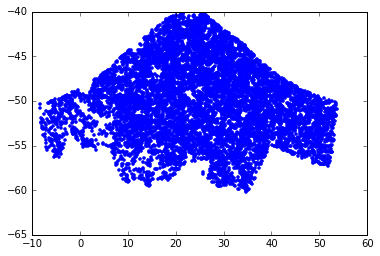

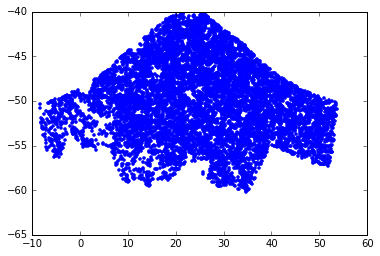

In [16]:
#buz = np.hstack(buz_list)
buz_list2 = []
for b in buz_list:
    b=b[b['MAG_I']<=21]
    buz_list2.append(b)

buz = np.hstack(buz_list)
buz2 = np.hstack(buz_list2)
bin_mag, avg_overdensity, error_over = CalculateOverdensity(buz, maglim_i, inputPix = HPIX, nside = 512)
bin_mag3, avg_overdensity3, error_over3 = CalculateOverdensity(buz2, maglim_i, inputPix = HPIX, nside = 512)
#print buz.size, buz2.size

25150 26116
0
0
0
0
0
0
3
3
8
29
52
110
152
195
82
34
5
0
0
0
25150 26116
0
0
0
0
0
0
3
3
8
29
52
110
152
195
82
34
5
0
0
0


/n/home00/lee.5922/.local/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/n/home00/lee.5922/.local/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


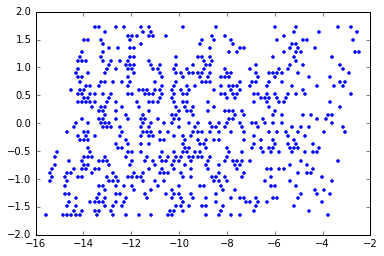

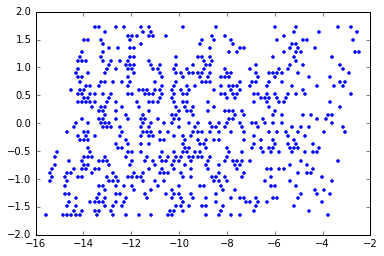

In [17]:
buz_train2 = buz_train[buz_train['MAG_I']<= 21]
#print buz_train.size, buz_train2.size
HPIX_train = [40, 60]
bin_mag2, avg_overdensity2, error_over2 = CalculateOverdensity(buz_train, maglim_i,\
                                                               inputPix=HPIX_train,nside = 512)
bin_mag4, avg_overdensity4, error_over4 = CalculateOverdensity(buz_train2, maglim_i,\
                                                               inputPix=HPIX_train, nside = 512)

In [ ]:
def chisquare_test(avg_overdensity, error_over):

    avg_overdensity = np.array(avg_overdensity)
    error_over = np.array(error_over)
    mask = np.ma.masked_invalid(avg_overdensity)
    m = ~mask.mask

    galaxy_density = avg_overdensity[m]
    err = error_over[m]
    bin = bin_mag[m]
    chisquare = np.sum((galaxy_density - 1.0)**2/err**2 )
    print chisquare/np.sum(m)

In [ ]:
chi1 = chisquare_test(avg_overdensity, error_over)
chi2 = chisquare_test(avg_overdensity2, error_over2)
chi3 = chisquare_test(avg_overdensity3, error_over3)
chi4 = chisquare_test(avg_overdensity4, error_over4)

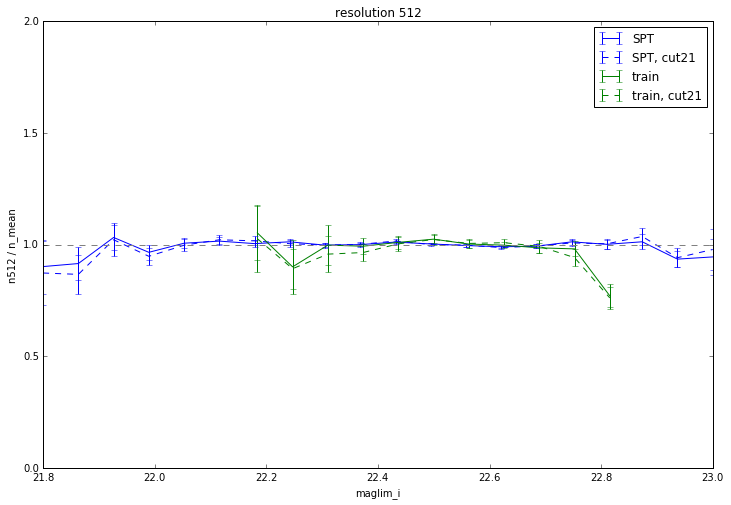

In [19]:
fig, ax = plt.subplots(1,1, figsize = (12, 8))
#ax.plot(maglim_i_256[bdmask][zeromask], overdensity, '.')
#ax.plot(bin_mag, avg_overdensity, '.')
ax.errorbar(bin_mag, avg_overdensity, yerr = error_over, color = 'blue', label = 'SPT')
ax.errorbar(bin_mag3, avg_overdensity3, yerr = error_over3, color = 'blue', linestyle = '--', label = 'SPT, cut21')
ax.errorbar(bin_mag2 + 0.005, avg_overdensity2, yerr = error_over2, color = 'green', label = 'train')
ax.errorbar(bin_mag4 + 0.005, avg_overdensity4, yerr = error_over4, color = 'green', linestyle='--',label = 'train, cut21')
ax.axhline(y=1, color='grey', linestyle='--')
ax.set_xlabel('maglim_i')
ax.set_ylabel('n512 / n_mean')
ax.set_title('resolution 512')
ax.set_ylim(0,2)
ax.set_xlim(21.8, 23)
ax.legend(loc='best')

In [ ]:
bdmask = maglim_i > 0
magInd = np.arange(maglim_i.size)[bdmask] 
r, d = hpHEALPixelToRaDec(magInd, nside = 4096)

In [ ]:
Hind_map = hpRaDecToRotatedHEALPixel(r,d, nside=8)
mask_map = Hind_map == 40

In [ ]:
fig, ax = plt.subplots()
ax.plot(r[mask_map],d[mask_map], '.')

In [ ]:
Hind = hpRaDecToRotatedHEALPixel(buz_train['RA'],buz_train['DEC'], nside=8)
#print np.sum(Hind == 40
mask = Hind == 40

spatialcheck(buz_train[mask])

In [ ]:
maglim_i_256 = hp.ud_grade(maglim_i, nside_out = nside, pest=True)
from utils import hpRaDecToRotatedHEALPixel
bdmask = maglim_i > 0
mapInd = np.arange(maglim_i_256.size)[bdmask]
#print mapInd
r, d = hpHEALPixelToRaDec(mapInd, nside = nside)
mapInd_rot = hpRaDecToRotatedHEALPixel( r, d, nside = nside )    
mapInd8 = hpRaDecToRotatedHEALPixel( r, d, nside = 8 )
maglim_i_8 = hp.ud_grade(maglim_i, nside_out = 8, pest=True)
#mapInd8 = np.arange(maglim_i_8.size)
buzInd8 = hpRaDecToRotatedHEALPixel( buz['RA'], buz['DEC'], nside = 8 )
effectivemask = np.in1d(mapInd8, np.array(inputPix) )
#print np.sum(effectivemask), mapInd8.size, len(set(buzInd8))
#mapInd = mapInd[effectivemask]
